
# Final Project of Network Science: Stack Overflow Tag Network
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#net">Network Data Analysis</a></li>


</ul>

<a id='intro'></a>
## Introduction

Stack Overflow is a question and answer site for professional and enthusiast programmers.It is a privately held website, the flagship site of the Stack Exchange Network, created in 2008 by Jeff Atwood and Joel Spolsky. For more info [Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow). Stack Overflow Team, they spend more time and energy about tech ecosystems and how technologies are related to each other. One place they see developers using tags at Stack Overflow is on their Developer Stories Stories, or professional profiles/CVs/resumes.. So I will explore how there is a relationship between computer software programs by using the network analysis method.

The dataset selected for the Network Analysis is the Stack Overflow Tag Network and can be found in [Kaggle](https://www.kaggle.com/stackoverflow/stack-overflow-tag-network).


### Meanings for Columns

>Node data frame : 
>*  ```name``` : Name of software programs(nodes).
>*  ```nodesize```  :  Proportional to how many developers have that tag in their developer story profile.
>*  ```group``` : Which group that node belongs to.

>Edge data frame :
>*  ```value``` :  Proportional to how correlated those two tags are (correlation coefficient * 100).
>*  ```source``` : Source of edges.
>*  ``` target``` : Target of edges.

<a id='wrangling'></a>
## Data Wrangling

> After uploading the data, I will perform the clearing, deleting, editing and explore operations in this section in order to get it ready for analysis. Therefore, I need some important libraries which are has been imported at below.

In [364]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np
from scipy import stats
import statistics as st
import sklearn.metrics
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
plt.style.use('fivethirtyeight')
import networkx as nx 
import pylab as plt 
from itertools import count 
from operator import itemgetter 
from networkx.drawing.nx_agraph import graphviz_layout 
import pylab
import plotly.express as px
import matplotlib.colors as mcolors

In [365]:
df_nodes = pd.read_csv("stack_network_nodes.csv")

In [366]:
df_links = pd.read_csv("stack_network_links.csv")

In [367]:
df_nodes.head()

,name,group,nodesize
0,html,6,272.45
1,css,6,341.17
2,hibernate,8,29.83
3,spring,8,52.84
4,ruby,3,70.14


In [368]:
df_links.head()

,source,target,value
0,azure,.net,20.933192
1,sql-server,.net,32.322524
2,asp.net,.net,48.407030
3,entity-framework,.net,24.370903
4,wpf,.net,32.350925


In [369]:
df_nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      115 non-null    object 
 1   group     115 non-null    int64  
 2   nodesize  115 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.8+ KB


In [370]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  490 non-null    object 
 1   target  490 non-null    object 
 2   value   490 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.6+ KB


In [434]:
fig = px.histogram(df_links, x="source",
                   title='Source Disturibution',
                   opacity=0.8,
                   color_discrete_sequence=['indianred'] # color of histogram bars
                   )
fig.show()

As we can see there is no empty columns so our data has already prepared for analyze. Let's start analyze!

<a id='net'></a>
## Network Data Analysis

<ul>
<li><a href="#cg">Creating Graph</a></li>
<li><a href="#bri">Bridges</a></li>
<li><a href="#cen">Centrality</a></li>
<li><a href="#cli">Clique</a></li>
<li><a href="#clu">Clustering</a></li>
<li><a href="#sho">Shortest Path </a></li>
    
</ul>


<a id='cg'></a>
### Creating of Graph 

In [373]:
G = nx.Graph()
for index, row in df_nodes.iterrows():
    G.add_node(row["name"],group = row["group"], nodesize = row["nodesize"] )
    
for index, row in df_links.iterrows():
    G.add_edge(row["source"], row["target"], weight = row["value"])

Once we created our graph we should look first graph info which is included nodes number of nodes, number of edges, and average degree. Our stack overflow tag has 115 different nodes and there are 245 edges linked to them. Degree is the measure of the total number of edges connected to a particular vertex. The average degree is the average number of edges per node. Therefore on average our one node(tag) has connected with ~4 other nodes.

In [374]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 115
Number of edges: 245
Average degree:   4.2609


In [429]:
density = nx.density(G)
print("Network density: %.4f" % density)

Network density: 0.0374


#### How is our network look like...

In [375]:
def draw_graph(G,size):
    nodes = G.nodes()
    color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
                 7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
                 13:'#d6dcff', 14:'#d2f5f0'}
    node_color= [color_map[d['group']] for n,d in G.nodes(data=True)]
    node_size = [d['nodesize']*10 for n,d in G.nodes(data=True)]
    pos = nx.drawing.spring_layout(G,k=0.80,iterations=60)
    plt.figure(figsize=size)
    nx.draw_networkx(G,alpha = 0.8,pos=pos,node_color=node_color,node_size=node_size,edge_color='#FFDEA2',width=1.0)
    plt.show()
    


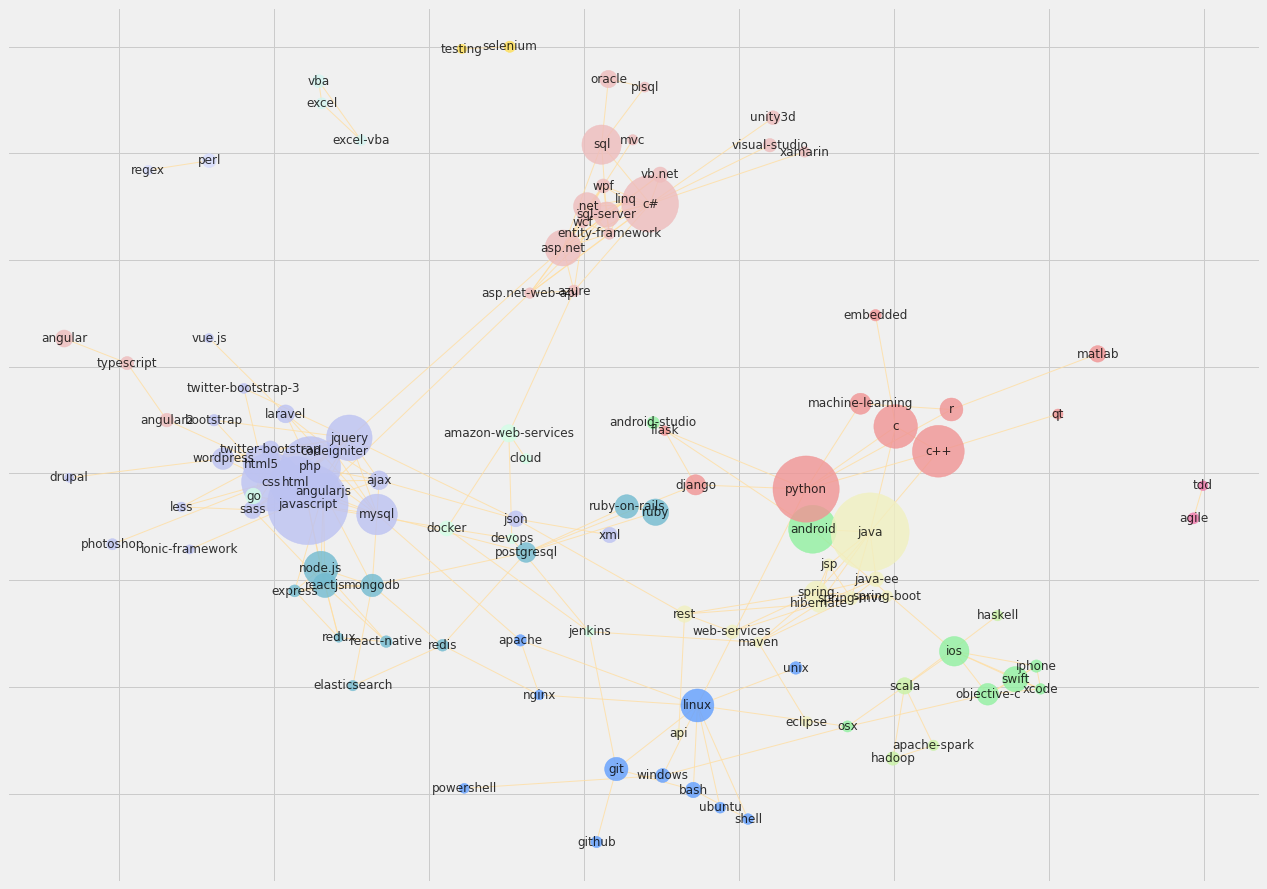

In [376]:
draw_graph(G,size=(20,15))

<a id='bri'></a>
## Bridges

A bridge in a graph is an edge whose removal causes the number of connected components of the graph to increase. Equivalently, a bridge is an edge that does not belong to any cycle.![Example](bridge.png)

A local bridge is an edge whose endpoints have no common neighbors. That is, the edge is not part of a triangle in the graph. ![Example1](localbridge.png)

In [377]:
nx.has_bridges(G)


True

In [378]:
bridges = list(nx.bridges(G))
print(bridges)

[('css', 'photoshop'), ('c', 'embedded'), ('c++', 'qt'), ('asp.net', 'mvc'), ('c#', 'xamarin'), ('c#', 'unity3d'), ('c#', 'visual-studio'), ('github', 'git'), ('android', 'android-studio'), ('scala', 'haskell'), ('angularjs', 'angular2'), ('angularjs', 'ionic-framework'), ('laravel', 'vue.js'), ('json', 'xml'), ('wordpress', 'drupal'), ('maven', 'eclipse'), ('linux', 'unix'), ('linux', 'ubuntu'), ('angular2', 'typescript'), ('typescript', 'angular'), ('tdd', 'agile'), ('rest', 'api'), ('testing', 'selenium'), ('docker', 'go'), ('amazon-web-services', 'cloud'), ('windows', 'powershell'), ('r', 'matlab'), ('regex', 'perl')]


In [379]:
local_brodges = list(nx.local_bridges(G))
print(local_brodges)

[('css', 'photoshop', inf), ('ios', 'android', 6), ('c', 'embedded', inf), ('c++', 'qt', inf), ('asp.net', 'jquery', 3), ('asp.net', 'mvc', inf), ('c#', 'xamarin', inf), ('c#', 'unity3d', inf), ('c#', 'visual-studio', inf), ('mysql', 'apache', 4), ('github', 'git', inf), ('git', 'jenkins', 7), ('android', 'android-studio', inf), ('android', 'java', 6), ('scala', 'haskell', inf), ('django', 'postgresql', 5), ('python', 'linux', 5), ('nginx', 'redis', 4), ('angularjs', 'angular2', inf), ('angularjs', 'ionic-framework', inf), ('angularjs', 'asp.net-web-api', 3), ('laravel', 'vue.js', inf), ('json', 'rest', 9), ('json', 'xml', inf), ('wordpress', 'drupal', inf), ('maven', 'eclipse', inf), ('maven', 'jenkins', 7), ('linux', 'unix', inf), ('linux', 'ubuntu', inf), ('angular2', 'typescript', inf), ('typescript', 'angular', inf), ('tdd', 'agile', inf), ('rest', 'api', inf), ('testing', 'selenium', inf), ('docker', 'go', inf), ('amazon-web-services', 'cloud', inf), ('amazon-web-services', 'azur

No handles with labels found to put in legend.


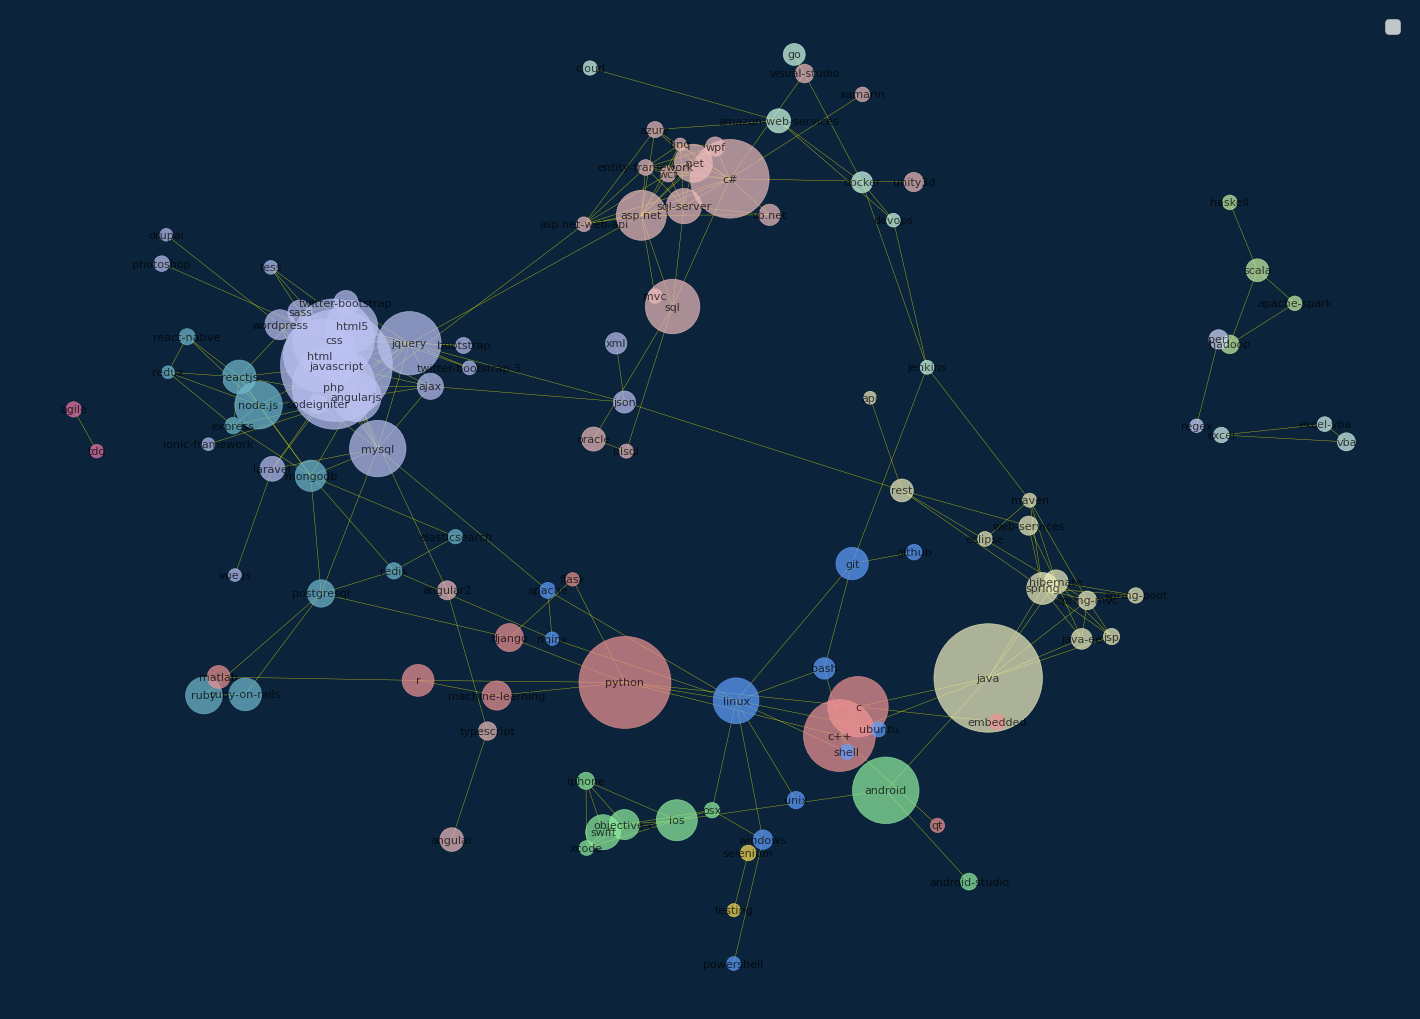

In [380]:
nodes = G.nodes()
degree = G.degree()
colors = [degree[n] for n in nodes]


pos = nx.nx.drawing.spring_layout(G,k=0.80,iterations=60)

cmap = plt.cm.viridis_r
cmap = plt.cm.Greys

vmin = min(colors)
vmax = max(colors)
color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
             7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
             13:'#d6dcff', 14:'#d2f5f0'}
node_color= [color_map[d['group']] for n,d in G.nodes(data=True)]
fig = plt.figure(figsize = (14,10), dpi=100)
node_size = [d['nodesize']*10 for n,d in G.nodes(data=True)]
nx.draw(G,pos,alpha = 0.7, nodelist = nodes, node_color = node_color, node_size =node_size , with_labels= True, font_size =8 , width = 0.3, cmap = cmap, edge_color ='yellow')
fig.set_facecolor('#0B243B')

plt.legend()
plt.show();


<a id='cen'></a>
### Centrality

* Degree
* Closeness
* Betweenness
* Eigenvector


In graph theory and network analysis, indicators of centrality identify the most important vertices within a graph.

![image.png](centrality1.png)

**Degree**

Degree is the simplest and the most common way of finding important nodes.

*When to use it*: For finding very connected individuals, popular individuals, individuals who are likely to hold most information or individuals who can quickly connect with the wider network.

In [381]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [382]:
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
print(G.nodes['linux'])

{'group': 5, 'nodesize': 108.54, 'degree': 10}


In [383]:
print("Top 10 nodes by degree:")
for d in sorted_degree[:10]:
    print(d)

Top 10 nodes by degree:
('jquery', 16)
('css', 14)
('c#', 14)
('asp.net', 13)
('angularjs', 13)
('javascript', 12)
('mysql', 11)
('html5', 10)
('php', 10)
('linux', 10)


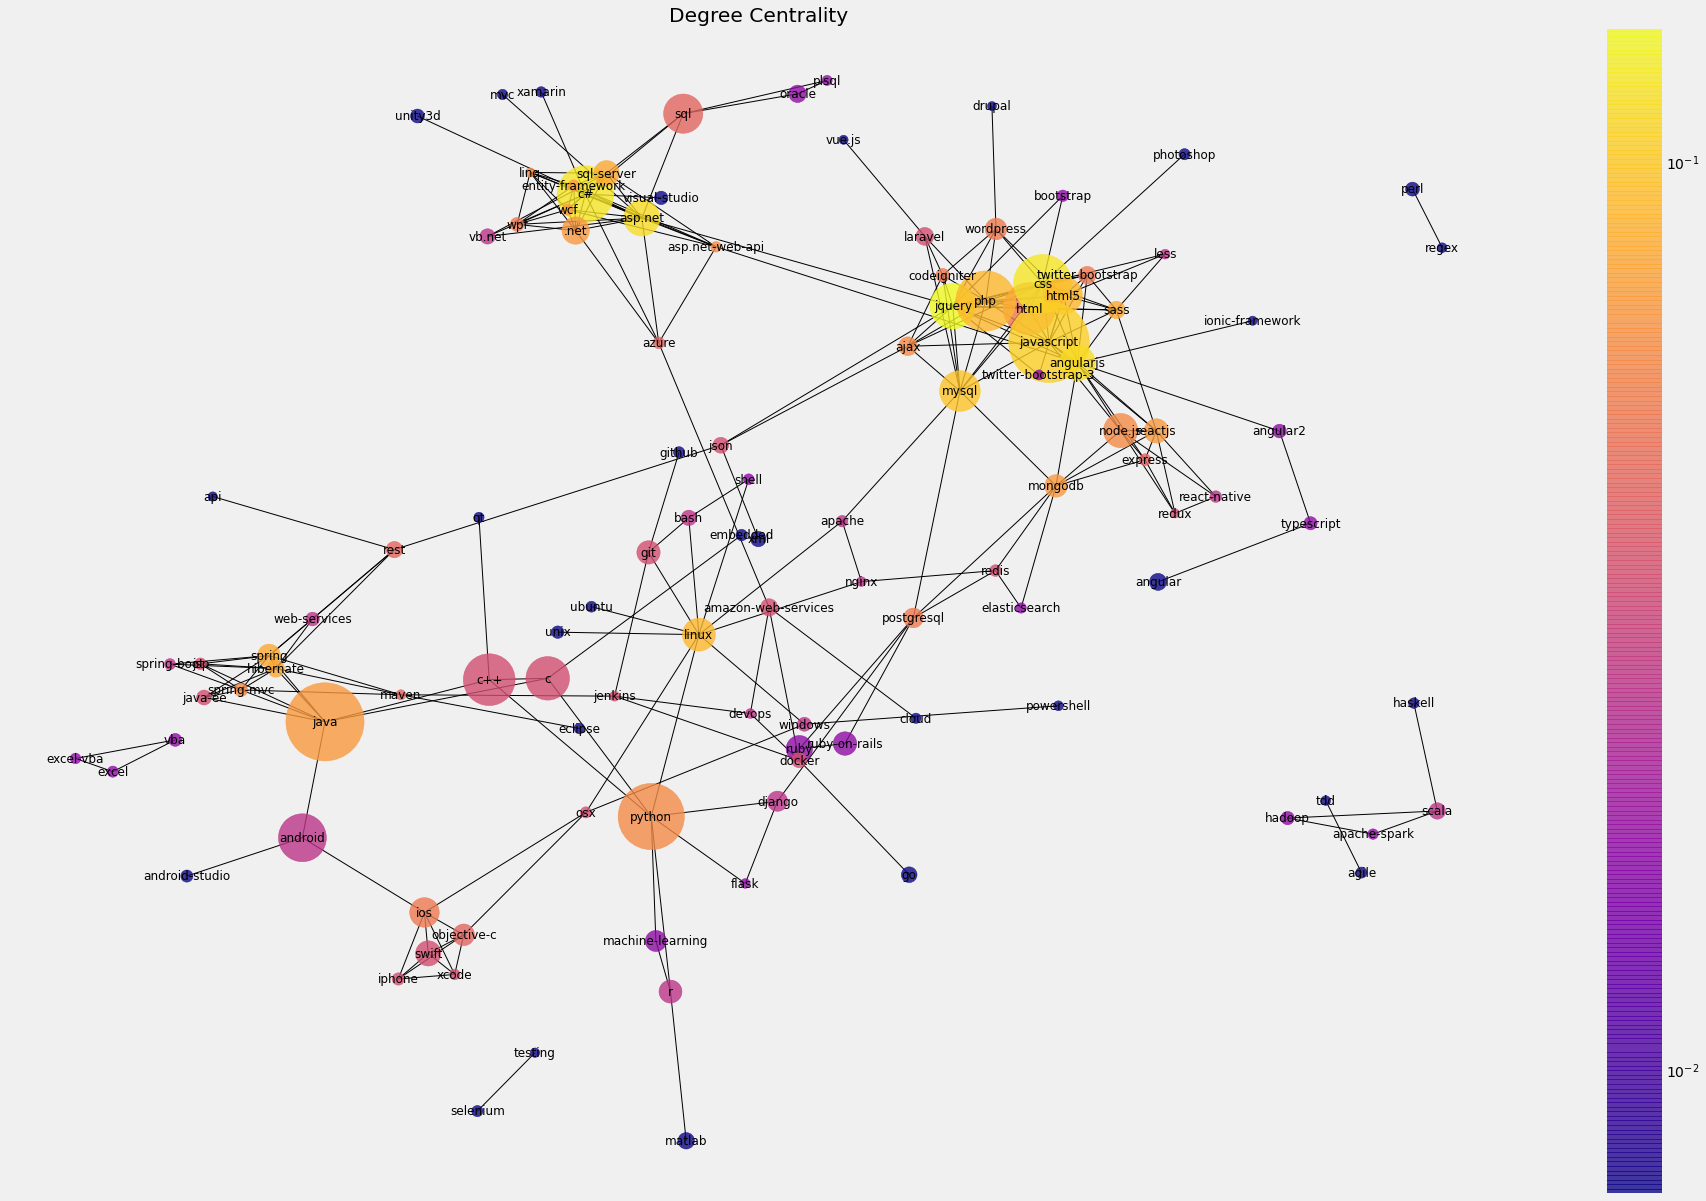

In [441]:
draw(G,nx.degree_centrality(G), 'Degree Centrality')

**Closeness**

We are calculating as the inverse of the sum of the shortest paths between the node on the chart and all other nodes. So, the more central a node is, the closer it is to all other nodes.

*When to use it*: For finding the individuals who are best placed to influence the entire network most quickly.

In [385]:
closeness_dict = nx.closeness_centrality(G)
sorted_closeness = sorted(closeness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by closeness centrality:")
for b in sorted_closeness[:10]:
    print(b[0],"%.4f" % b[1])

Top 10 nodes by closeness centrality:
jquery 0.2896
mysql 0.2779
ajax 0.2586
css 0.2579
javascript 0.2571
angularjs 0.2571
apache 0.2549
php 0.2514
html 0.2472
asp.net 0.2465


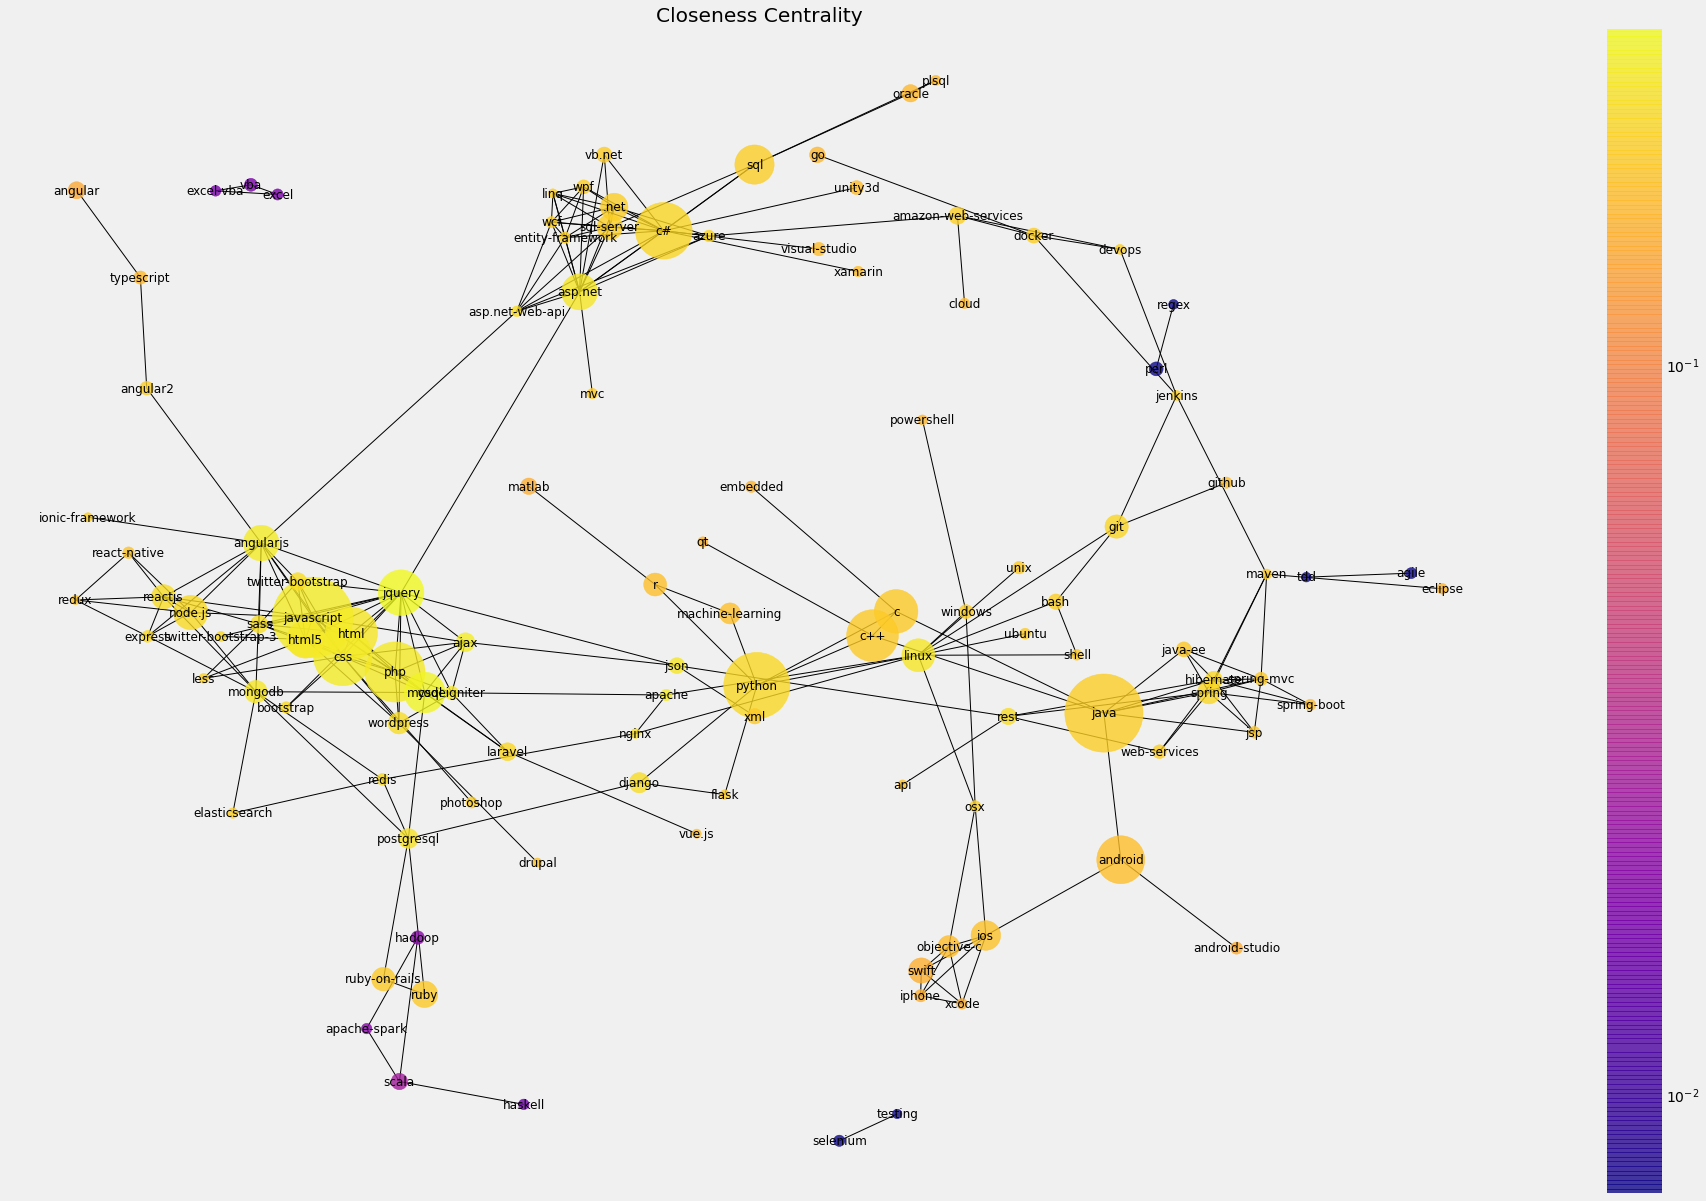

In [442]:
draw(G,nx.closeness_centrality(G), 'Closeness Centrality')

**Betweenness**


The betweenness centrality captures how much a given node is in-between others. This metric is measured with the number of shortest paths (between any couple of nodes in the graphs) that passes through the target node . This score is moderated by the total number of shortest paths existing between any couple of nodes of the graph. The target node would have a high betweenness centrality if it appears in many shortest paths. [Science Direct](https://www.sciencedirect.com/topics/computer-science/betweenness-centrality)

*When to use it*: For finding the individuals who influence the flow around a system.

In [387]:
betweenness_dict = nx.betweenness_centrality(G) 
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by betweenness centrality:")
for b in sorted_betweenness[:10]:
    print(b[0],"%.4f" % b[1])

Top 10 nodes by betweenness centrality:
jquery 0.2555
linux 0.2084
mysql 0.1977
asp.net 0.1741
apache 0.1309
json 0.1232
angularjs 0.1229
rest 0.1137
python 0.1102
postgresql 0.0876


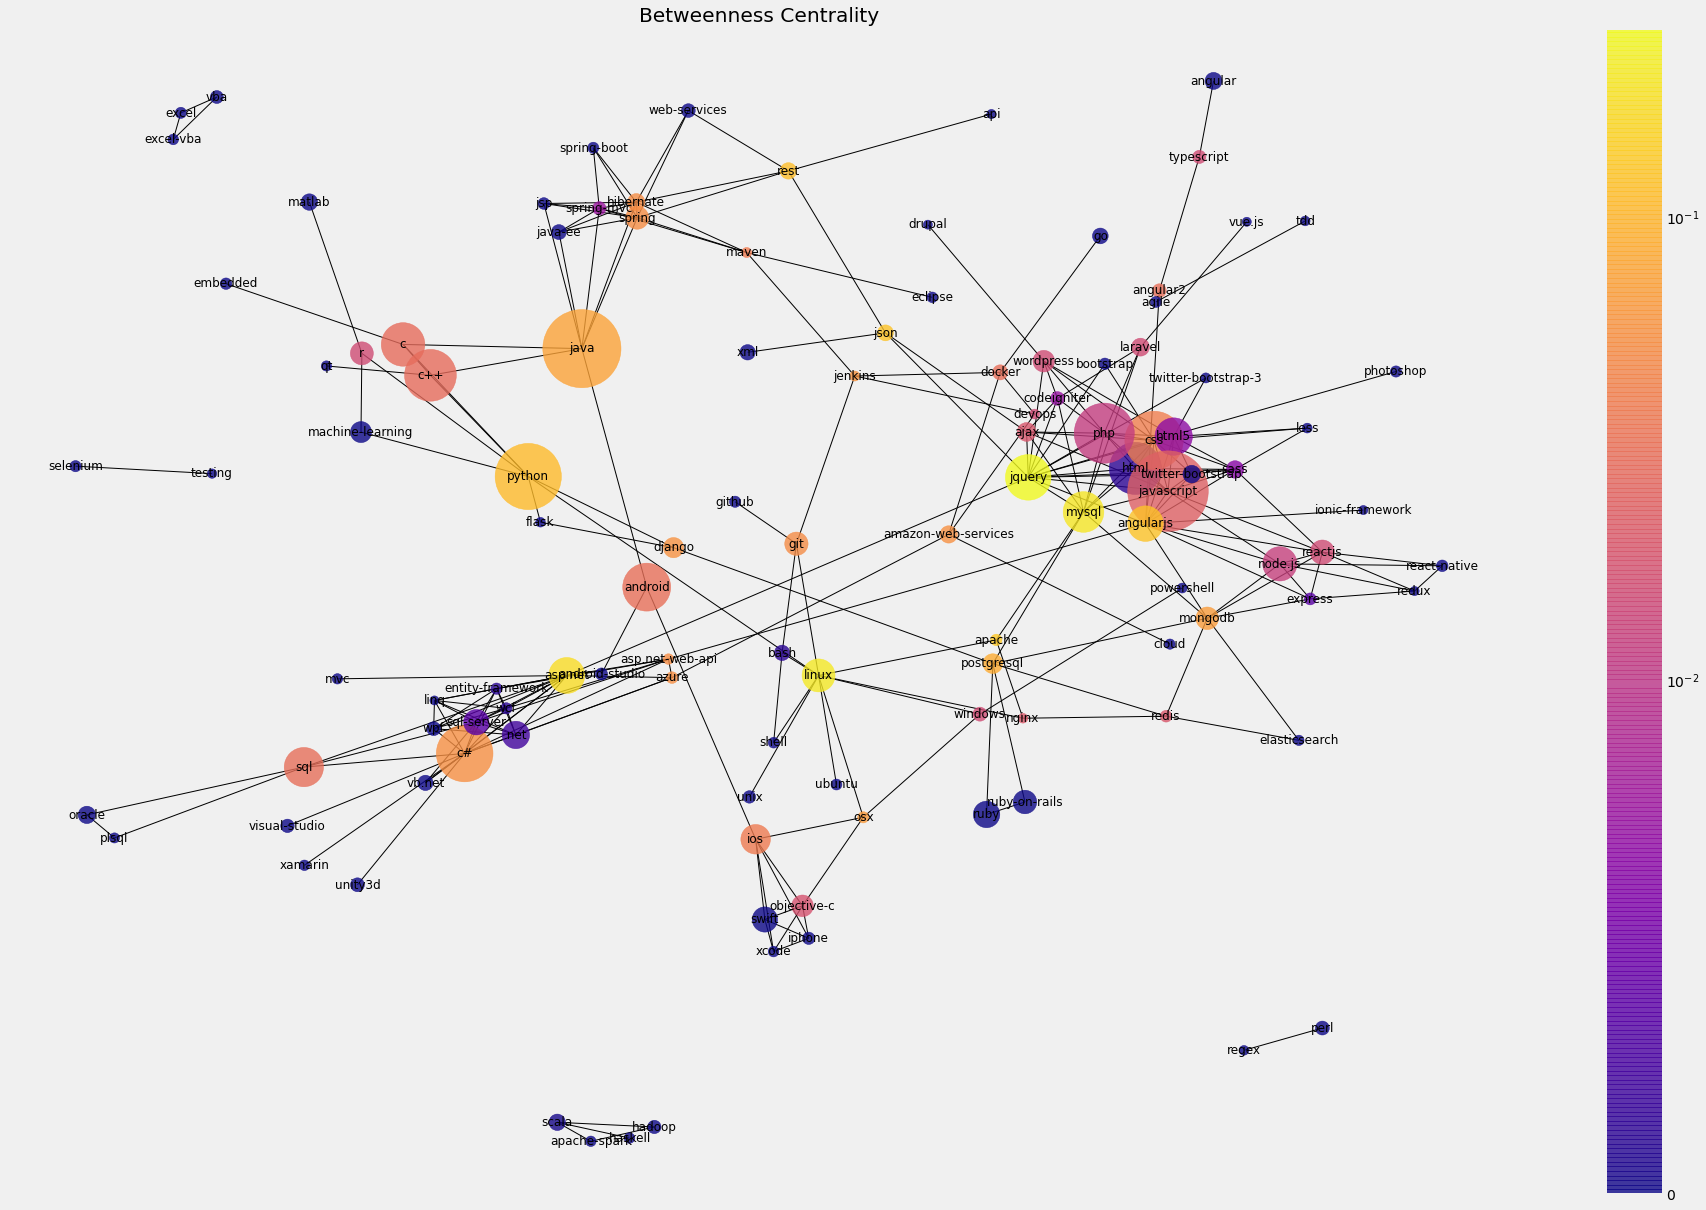

In [444]:
draw(G,nx.betweenness_centrality(G) , 'Betweenness Centrality')

**Eigenvector**

Like degree centrality, EigenCentrality measures a node’s influence based on the number of links it has to other nodes in the network. EigenCentrality then goes a step further by also taking into account how well connected a node is, and how many links their connections have, and so on through the network.

*When to use it*: EigenCentrality is a good ‘all-round’ SNA score, handy for understanding human social networks, but also for understanding networks like malware propagation.


In [389]:
eigenvector_dict = nx.eigenvector_centrality(G)
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by eigenvector centrality:")
for b in sorted_eigenvector[:10]:
    print(b[0],"%.4f" % b[1])

Top 10 nodes by eigenvector centrality:
jquery 0.3658
css 0.3387
javascript 0.3256
html5 0.2681
php 0.2653
angularjs 0.2652
sass 0.2521
mysql 0.2393
twitter-bootstrap 0.2071
html 0.2038


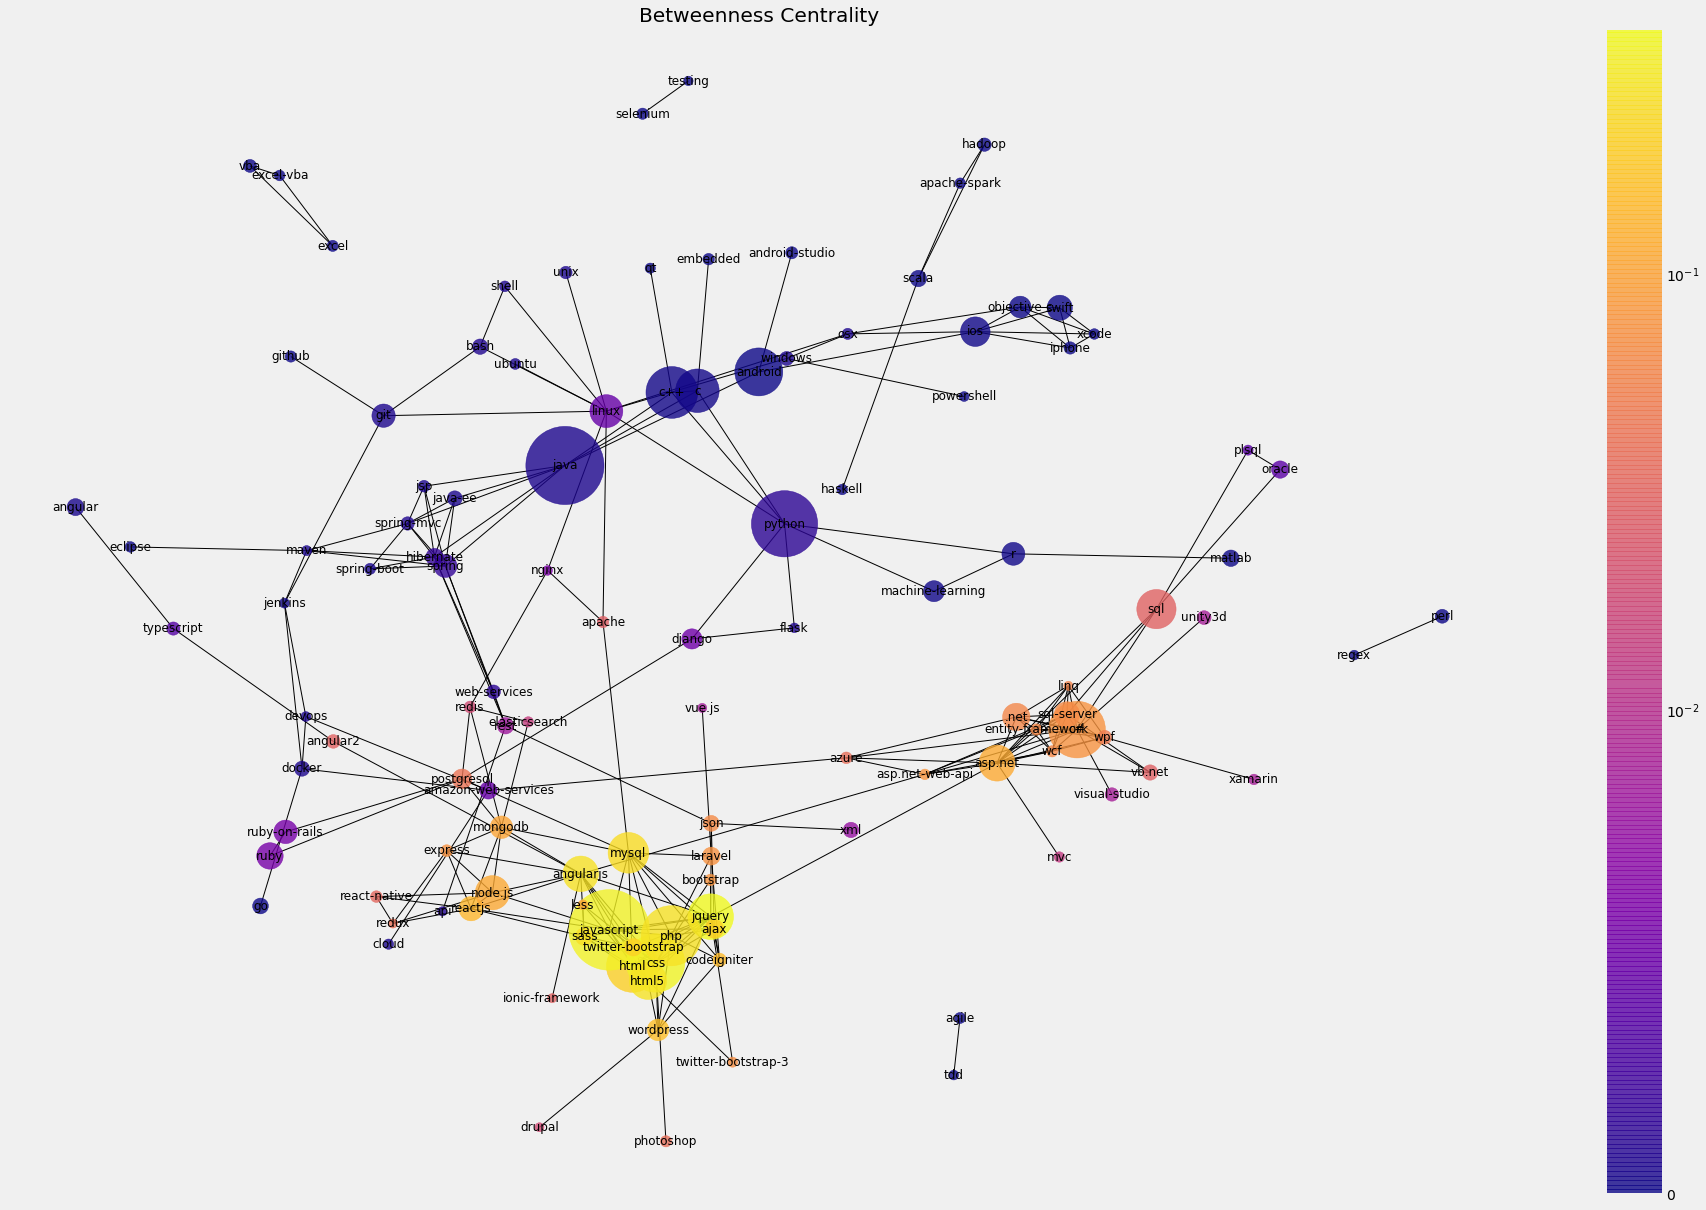

In [451]:
draw(G,nx.eigenvector_centrality(G) , 'Betweenness Centrality')

In [450]:
def draw(G, measures, measure_name):
    plt.figure(figsize=(30,20))
    node_size = [d['nodesize']*10 for n,d in G.nodes(data=True)]
    pos = nx.drawing.spring_layout(G,k=0.80,iterations=60)
    
    nodes = nx.draw_networkx_nodes(G,alpha = 0.8,pos=pos, node_size=node_size, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    labels = nx.draw_networkx_labels(G,pos)
    edges = nx.draw_networkx_edges(G,pos)
    
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

**Our most important node is jQuery!!!!!**

**What is the jQuery?**

**The purpose of jQuery is to make it much easier to use JavaScript on your website.**

**jQuery takes a lot of common tasks that require many lines of JavaScript code to accomplish, and wraps them into methods that you can call with a single line of code.**



<a id='cli'></a>
### Clique

A clique is a subset of vertices of an undirected graph G such that every two distinct vertices in the clique are adjacent; that is, its induced subgraph is complete. So,If there is adjacent relationship between all nodes of a subset of graph nodes, we can say that it is one of the clicks.



![Example2](cliques.png)

In [392]:
# Example of clique
list(nx.find_cliques(G))[0:3]

[['spring-boot', 'spring', 'hibernate', 'spring-mvc'],
 ['mvc', 'asp.net'],
 ['windows', 'powershell']]

I will find the max clique nodes and edges and I will draw subgraph with them to see which are the technologies are connected with all others.

In [393]:
sorted_cliques = sorted(list(nx.find_cliques(G)),key=len)
list_len = [ ]
for clique in sorted_cliques:
    list_len.append(len(clique))
print(list_len)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7]


In [394]:
# As we can see max cliques has 7 nodes but to we can also darw together with 6 nodes to see other technoligies.
# So that's wy we can take last 6 cliques.
max_clique_nodes = set()

for nodelist in sorted_cliques[-6:-1]:
    for node in nodelist:
        max_clique_nodes.add(node)

In [395]:
max_clique = G.subgraph(max_clique_nodes)

print(nx.info(max_clique))

Name: 
Type: Graph
Number of nodes: 16
Number of edges: 53
Average degree:   6.6250


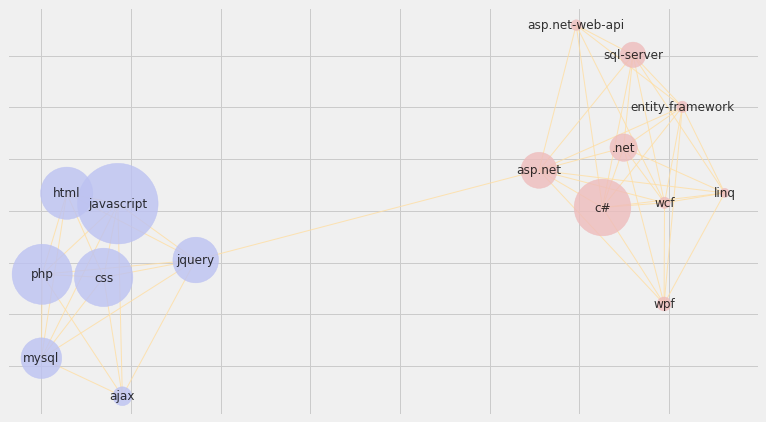

In [401]:
draw_graph(max_clique,size=(12,7))

<a id='clu'></a>
### Clustering Coefficient  

In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together.

![Example4](Clustring.png)

In [403]:
clustring_dic = dict(nx.clustering(G))
list_max_cliques = list(max_clique_nodes)
filtered_dic = {key: clustring_dic[key] for key in list_max_cliques }
sorted_dic = {k: v for k, v in sorted(filtered_dic.items(), key=lambda item: item[1])}
for k,v in sorted_dic.items():
    print(k+" :"+"%.4f" % v)

jquery :0.3333
c# :0.3407
mysql :0.3636
css :0.3956
asp.net :0.3974
javascript :0.5152
asp.net-web-api :0.5714
php :0.5778
sql-server :0.6389
ajax :0.6667
.net :0.7857
entity-framework :0.8571
wcf :0.8571
html :0.8667
linq :0.9524
wpf :1.0000


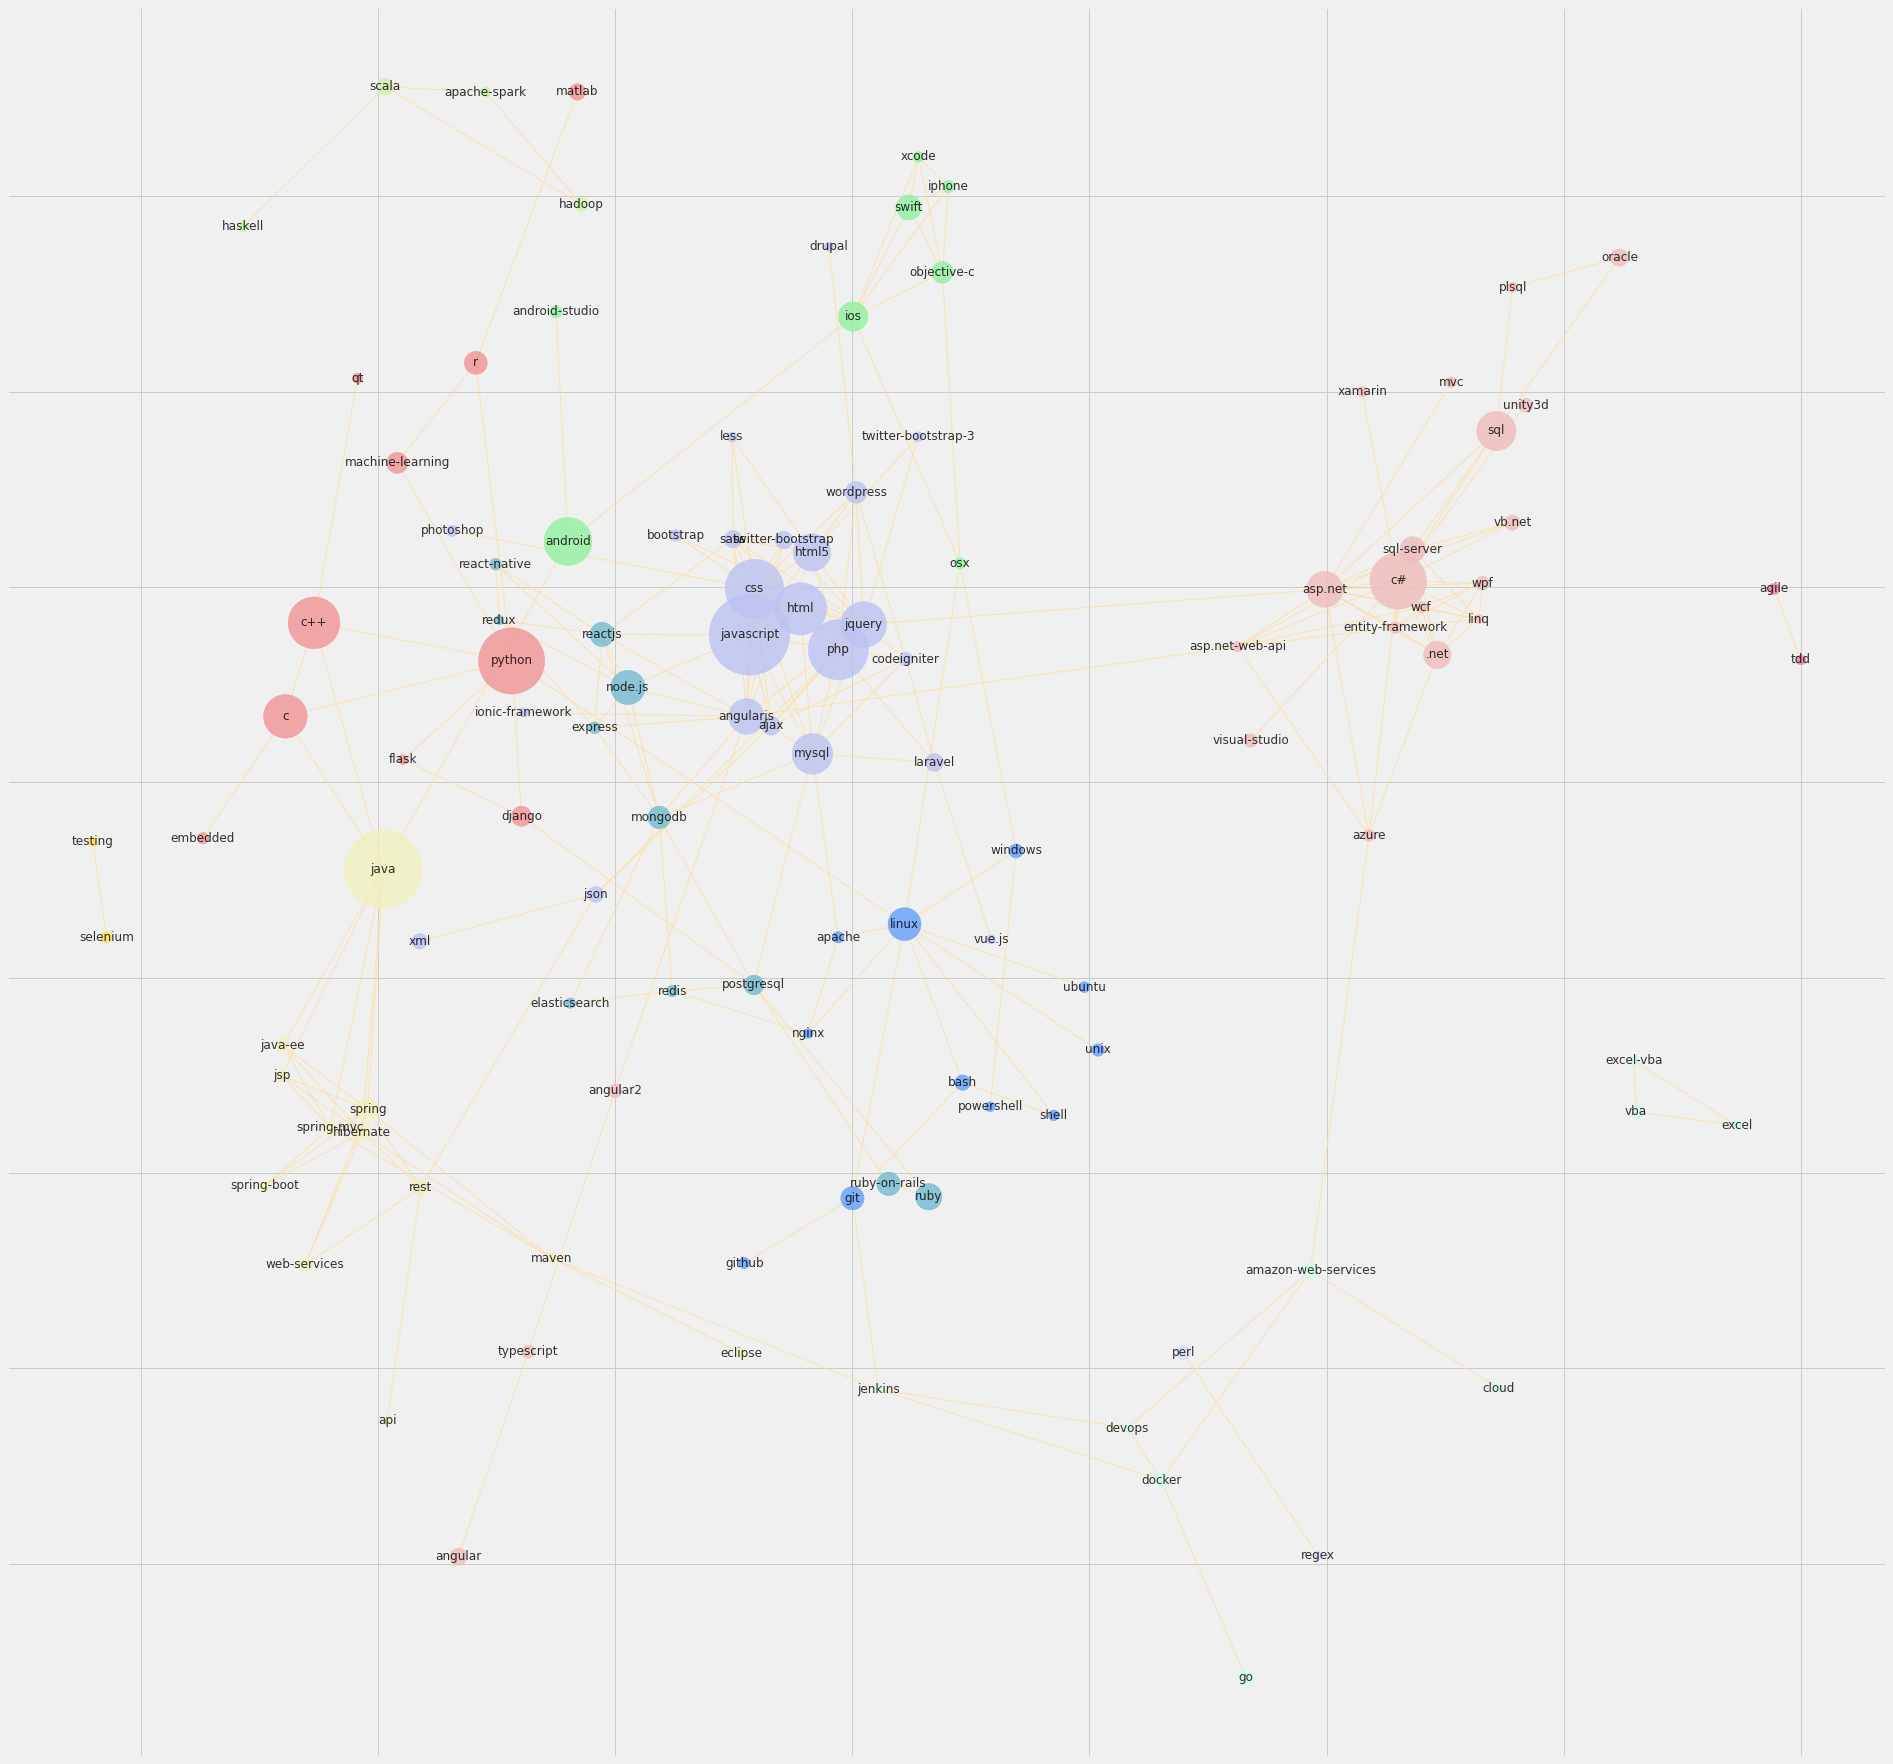

In [406]:
draw_graph(G,size=(30,30))

<a id='sho'></a>
### Shortest Path


In graph theory, the shortest path problem is the problem of finding a path between two vertices (or nodes) in a graph such that the sum of the weights of its constituent edges is minimized. So the algorithm find the shortest path between two nodes. If the network is huge this algorithm is really helpful. Let's find the some shortest path!

In [416]:
def find_path(source,target):
    fell_wh = nx.shortest_path(G, source=source, target=target)

    print("Shortest path between "+ source + "and"+target +" : ",fell_wh,"and the length of that path is", len(fell_wh)-1)

In [418]:
find_path('python','matlab')

Shortest path between pythonandmatlab :  ['python', 'r', 'matlab'] and the length of that path is 2


In [419]:
find_path('python','windows')

Shortest path between pythonandwindows :  ['python', 'linux', 'windows'] and the length of that path is 2
